<a href="https://colab.research.google.com/github/ManasChandan/Activity_Recognition/blob/main/ACTIVITY_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
path = "/content/gdrive/My Drive/DataSets/Data.zip"

In [ ]:
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
labels_dict = {'Abuse':0,'Arrest':1,'Arson':2,'Assault':3,'Burglary':4,'Explosion':5,'Fighting':6,
               'RoadAccidents':7,'Robbery':8,'Shooting':9,'Shoplifting':10,'Stealing':11,'Vandalism':12}

In [ ]:
def prepare_data(path):
    labels = []
    final_Matrice = []
    for activities in os.listdir(path):
        videos = path + "/" + activities
        # activities has the name
        print(activities)
        for video in os.listdir(videos):
            frames = videos + "/" + video + "/Frames"
            image_Videos = []
            for frame in os.listdir(frames):
                filepath = frames + "/" + frame
                image = cv2.imread(filepath)
                image = cv2.resize(image , (80,80))
                image_Videos.append(image)
            labels.append(labels_dict[activities])
            final_Matrice.append(image_Videos)
    labels = to_categorical(labels)
    final_Matrice = np.array(final_Matrice)
    final_Matrice = final_Matrice / 255.0

    X_train, X_test, y_train, y_test = train_test_split(final_Matrice, labels, test_size=0.15)

    print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_data("/content/Data")

Burglary
Fighting
Stealing
Shoplifting
Explosion
Assault
RoadAccidents
Arrest
Arson
Abuse
Robbery
Vandalism
Shooting
(236, 32, 80, 80, 3) (42, 32, 80, 80, 3) (236, 13) (42, 13)


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D , MaxPooling2D
from tensorflow.keras.layers import BatchNormalization , Activation
from tensorflow.keras.regularizers import L2

In [ ]:
X_train[0].shape

(32, 80, 80, 3)

In [ ]:
def add_default_block(model, kernel_filters, initals , reg_lambda):
  model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                             kernel_initializer=initals, kernel_regularizer=L2(l=reg_lambda))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                             kernel_initializer=initals, kernel_regularizer=L2(l=reg_lambda))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
  return model

In [ ]:
def create_model():
  initialiser = 'glorot_uniform'
  reg_lambda  = 0.001
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same',
                                          kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda)),
                                    input_shape=(32,80,80,3)))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
  model = add_default_block(model, 64,  initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 128, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 256, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 512, initals=initialiser, reg_lambda=reg_lambda)
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(256, return_sequences=False, dropout=0.5))
  model.add(Dense(13, activation='softmax'))
  return model

In [ ]:
model = create_model()

In [ ]:
model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
model.fit(X_train , y_train, epochs = 1)

8/8 [==============================] - 3s 395ms/step - loss: 4.3268 - accuracy: 0.1017


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 32, 40, 40, 32)    4736      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 32, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 32, 38, 38, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 32, 38, 38, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 32, 38, 38, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 32, 19, 19, 32)    0

In [ ]:
data = model.fit(X_train , y_train , batch_size=64 , epochs = 100 , validation_data=(X_test , y_test))

Epoch 1/100
4/4 [==============================] - 7s 2s/step - loss: 4.0906 - accuracy: 0.1568 - val_loss: 4.2303 - val_accuracy: 0.1190
Epoch 2/100
4/4 [==============================] - 2s 495ms/step - loss: 4.0235 - accuracy: 0.1907 - val_loss: 4.2299 - val_accuracy: 0.1190
Epoch 3/100
4/4 [==============================] - 2s 492ms/step - loss: 3.9711 - accuracy: 0.2203 - val_loss: 4.2217 - val_accuracy: 0.1190
Epoch 4/100
4/4 [==============================] - 2s 505ms/step - loss: 3.8856 - accuracy: 0.2500 - val_loss: 4.2905 - val_accuracy: 0.1190
Epoch 5/100
4/4 [==============================] - 2s 495ms/step - loss: 3.8062 - accuracy: 0.2458 - val_loss: 4.4213 - val_accuracy: 0.1190
Epoch 6/100
4/4 [==============================] - 2s 495ms/step - loss: 3.7204 - accuracy: 0.2754 - val_loss: 4.5340 - val_accuracy: 0.1190
Epoch 7/100
4/4 [==============================] - 2s 500ms/step - loss: 3.6001 - accuracy: 0.3136 - val_loss: 4.6402 - val_accuracy: 0.1190
Epoch 8/100
4/4 

In [ ]:
def create_new_model():
  initialiser = 'glorot_uniform'
  reg_lambda  = 0.001
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same',
                                          kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda)),
                                    input_shape=(32,80,80,3)))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
  model = add_default_block(model, 64,  initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 128, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 256, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 512, initals=initialiser, reg_lambda=reg_lambda)
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(256, return_sequences=True))
  model.add(LSTM(256, return_sequences=False, dropout=0.5))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(13, activation='softmax'))
  return model

In [ ]:
model_new = create_new_model()

In [ ]:
model_new.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
model_new.fit(X_train , y_train , epochs=1)

8/8 [==============================] - 2s 256ms/step - loss: 4.2127 - accuracy: 0.1314


In [ ]:
data_new = model_new.fit(X_train , y_train , batch_size=64 , epochs = 100 , validation_data=(X_test , y_test))

Epoch 1/100
4/4 [==============================] - 3s 771ms/step - loss: 4.0880 - accuracy: 0.1356 - val_loss: 4.1261 - val_accuracy: 0.1190
Epoch 2/100
4/4 [==============================] - 2s 516ms/step - loss: 3.9903 - accuracy: 0.2034 - val_loss: 4.0981 - val_accuracy: 0.0714
Epoch 3/100
4/4 [==============================] - 2s 531ms/step - loss: 3.8807 - accuracy: 0.2161 - val_loss: 4.1182 - val_accuracy: 0.1190
Epoch 4/100
4/4 [==============================] - 2s 532ms/step - loss: 3.7719 - accuracy: 0.2034 - val_loss: 4.1546 - val_accuracy: 0.1190
Epoch 5/100
4/4 [==============================] - 2s 526ms/step - loss: 3.7264 - accuracy: 0.2246 - val_loss: 4.0849 - val_accuracy: 0.1190
Epoch 6/100
4/4 [==============================] - 2s 535ms/step - loss: 3.6215 - accuracy: 0.2076 - val_loss: 4.0905 - val_accuracy: 0.1190
Epoch 7/100
4/4 [==============================] - 2s 541ms/step - loss: 3.5511 - accuracy: 0.2161 - val_loss: 4.1174 - val_accuracy: 0.1190
Epoch 8/100
4

In [ ]:
def create_model_three():
  initialiser = 'glorot_uniform'
  reg_lambda  = 0.001
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same',
                                          kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda)),
                                    input_shape=(32,80,80,3)))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
  model = add_default_block(model, 64,  initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 128, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 256, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 512, initals=initialiser, reg_lambda=reg_lambda)
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(256, return_sequences=True))
  model.add(LSTM(256, return_sequences=False, dropout=0.5))
  model.add(Dense(13, activation='softmax'))
  return model

In [ ]:
model_three = create_model_three()

In [ ]:
model_three.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
model_three.fit(X_train , y_train , epochs = 1)

8/8 [==============================] - 2s 260ms/step - loss: 4.2650 - accuracy: 0.1186


In [ ]:
model_three.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_72 (TimeDis (None, 32, 40, 40, 32)    4736      
_________________________________________________________________
time_distributed_73 (TimeDis (None, 32, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_74 (TimeDis (None, 32, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_75 (TimeDis (None, 32, 38, 38, 32)    9248      
_________________________________________________________________
time_distributed_76 (TimeDis (None, 32, 38, 38, 32)    128       
_________________________________________________________________
time_distributed_77 (TimeDis (None, 32, 38, 38, 32)    0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 32, 19, 19, 32)   

In [ ]:
data_three = model_three.fit(X_train , y_train , batch_size=64 , epochs = 100 , validation_data=(X_test , y_test))

Epoch 1/100
4/4 [==============================] - 3s 777ms/step - loss: 4.1035 - accuracy: 0.1059 - val_loss: 4.1590 - val_accuracy: 0.1190
Epoch 2/100
4/4 [==============================] - 2s 532ms/step - loss: 4.0008 - accuracy: 0.2034 - val_loss: 4.1453 - val_accuracy: 0.1190
Epoch 3/100
4/4 [==============================] - 2s 528ms/step - loss: 3.9581 - accuracy: 0.1864 - val_loss: 4.1782 - val_accuracy: 0.1190
Epoch 4/100
4/4 [==============================] - 2s 526ms/step - loss: 3.8452 - accuracy: 0.2288 - val_loss: 4.1431 - val_accuracy: 0.1190
Epoch 5/100
4/4 [==============================] - 2s 531ms/step - loss: 3.7342 - accuracy: 0.2331 - val_loss: 4.1493 - val_accuracy: 0.1190
Epoch 6/100
4/4 [==============================] - 2s 528ms/step - loss: 3.6570 - accuracy: 0.2415 - val_loss: 4.2684 - val_accuracy: 0.1190
Epoch 7/100
4/4 [==============================] - 2s 535ms/step - loss: 3.6208 - accuracy: 0.2288 - val_loss: 4.2240 - val_accuracy: 0.1190
Epoch 8/100
4

In [ ]:
from tensorflow.keras.layers import Bidirectional

def create_model_four():
  initialiser = 'glorot_uniform'
  reg_lambda  = 0.001
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same',
                                          kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda)),
                                    input_shape=(32,80,80,3)))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer=initialiser, kernel_regularizer=L2(l=reg_lambda))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
  model = add_default_block(model, 64,  initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 128, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 256, initals=initialiser, reg_lambda=reg_lambda)
  model = add_default_block(model, 512, initals=initialiser, reg_lambda=reg_lambda)
  model.add(TimeDistributed(Flatten()))
  model.add(Bidirectional(LSTM(256, return_sequences=False, dropout=0.5)))
  model.add(Dense(13, activation='softmax'))
  return model

In [ ]:
model_four = create_model_four()

In [ ]:
model_four.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
model_four.fit(X_train , y_train , epochs = 1)

8/8 [==============================] - 2s 254ms/step - loss: 4.5333 - accuracy: 0.0890


In [ ]:
data_four = model_four.fit(X_train , y_train ,batch_size=64 , epochs = 100 , validation_data=(X_test , y_test))

Epoch 1/100
4/4 [==============================] - 3s 761ms/step - loss: 4.1576 - accuracy: 0.1525 - val_loss: 4.2268 - val_accuracy: 0.1190
Epoch 2/100
4/4 [==============================] - 2s 520ms/step - loss: 4.0780 - accuracy: 0.1780 - val_loss: 4.2600 - val_accuracy: 0.0714
Epoch 3/100
4/4 [==============================] - 2s 524ms/step - loss: 4.0018 - accuracy: 0.2119 - val_loss: 4.2549 - val_accuracy: 0.1190
Epoch 4/100
4/4 [==============================] - 2s 530ms/step - loss: 3.9061 - accuracy: 0.2288 - val_loss: 4.2592 - val_accuracy: 0.1190
Epoch 5/100
4/4 [==============================] - 2s 537ms/step - loss: 3.8669 - accuracy: 0.2161 - val_loss: 4.3410 - val_accuracy: 0.1190
Epoch 6/100
4/4 [==============================] - 2s 538ms/step - loss: 3.7576 - accuracy: 0.2415 - val_loss: 4.4765 - val_accuracy: 0.1190
Epoch 7/100
4/4 [==============================] - 2s 527ms/step - loss: 3.6709 - accuracy: 0.2754 - val_loss: 4.6157 - val_accuracy: 0.1190
Epoch 8/100
4

In [ ]:
answers = model_four.evaluate(X_train , y_train)
print(answers)

8/8 [==============================] - 1s 93ms/step - loss: 2.0698 - accuracy: 0.6695
[2.0698370933532715, 0.6694915294647217]


In [ ]:
model_four.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_108 (TimeDi (None, 32, 40, 40, 32)    4736      
_________________________________________________________________
time_distributed_109 (TimeDi (None, 32, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_110 (TimeDi (None, 32, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_111 (TimeDi (None, 32, 38, 38, 32)    9248      
_________________________________________________________________
time_distributed_112 (TimeDi (None, 32, 38, 38, 32)    128       
_________________________________________________________________
time_distributed_113 (TimeDi (None, 32, 38, 38, 32)    0         
_________________________________________________________________
time_distributed_114 (TimeDi (None, 32, 19, 19, 32)   

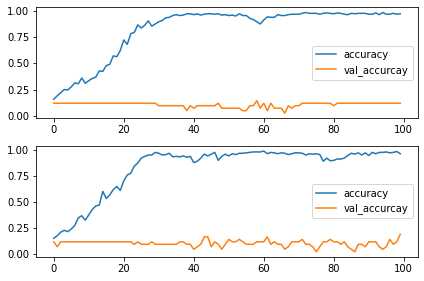

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(data.history['accuracy'],label = 'accuracy')
plt.plot(data.history['val_accuracy'],label = 'val_accurcay')
plt.legend()
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(data_four.history['accuracy'],label = 'accuracy')
plt.plot(data_four.history['val_accuracy'],label = 'val_accurcay')
plt.legend()
plt.tight_layout()